In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import random
import json
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# !pip install spacy
# !pip install gensim
# !pip install scipy==1.10.1
# !pip install wordcloud

In [3]:
sns.set()
import re
import spacy
from wordcloud import WordCloud
import gensim

In [4]:
from scipy import stats
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

In [5]:
# !python -m spacy download en_core_web_sm

In [6]:
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'] )  # disable=['parser', 'ner']

In [7]:
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

In [8]:
def token_allowed(token):
    '''Check if the token is valid.'''
    if (not token or not token.text.strip() or token.is_stop
        or token.lemma_ in spacy_stopwords or token.is_punct or token.like_num or token.pos_ in ['SYM','CCONJ','NUM']):
        return False
    return True

def process_token(token):
    '''Lemmatize, strip and lowercase the token.'''
    return token.lemma_.strip().lower()

def text_preprocessing(text):
    return " ".join([process_token(token) for token in nlp_model(text) if token_allowed(token)])

In [9]:
def preprocessing_for_gensim(texts):
    '''Preprocess a list of text reviews.'''
    processed_list = []
    for text in texts:
        text = re.sub('\'ll', ' ', text)
        text = re.sub('\'d', ' ', text)
        text = re.sub('\'m', ' ', text)
        text = re.sub('\'re', ' ', text)
        text = re.sub('\'s', ' ', text)
        text = re.sub('\'ve', ' ', text)
        text = re.sub("\n't", " ", text)
                
        processed_list.append([process_token(token) for token in nlp_model(text) if token_allowed(token)])
    return processed_list

In [10]:
# Load Nashville reviews
nash_reviews_df = pd.read_pickle("nash_reviews.pkl")


In [11]:
# Load Nashville restaurants
nash_restaurants_df = pd.read_pickle("nash_restaurants.pkl")

In [12]:
nash_reviews_df[nash_reviews_df['stars'] >= 4].head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
39,E9AB7V4z8xrt2uPF7T55FQ,iYY5Ii1LGpZCpXFkHlMefw,Zx7n8mdt8OzLRXVzolXNhQ,5.0,0,0,0,Amazing biscuits and (fill in the blank). Grea...,2018-04-27 23:03:21
43,qGQvUHmC02PAZW3H1WTIfw,RRTQpg8hutdimzAYuP_Hbw,eaJCpC6IhYphj7bwCDHTwQ,5.0,0,0,0,Stopped by after a Sunday morning walk in the ...,2015-08-30 13:41:47
82,DOeEDBfsrNph0ktNkYYFnQ,qVYilGRmY6uemAy_tDpfuA,9OtFX3YzG5keaUMOWU1imA,5.0,4,0,0,Man. This place is nice. The bartender was awe...,2014-05-26 01:56:19
91,xumAI7br1X67OY_bU_Yqhg,jEmClJb6wjfDUksVMO_Jjg,X_E7U2lVNEwbH_gpOBmAHQ,5.0,0,0,0,This place was so chill and relaxing. When I c...,2017-06-17 17:46:55
105,9IG9eB3K-RdIonPBuZ0psw,t2IL-HIXQKd6iZ6cIY8kcg,jOOOrH5n2ijnsZKxzPSAiw,5.0,0,0,0,This is one of the busiest Chick fil A's I've ...,2016-04-23 15:13:10


In [13]:
business_indices = nash_reviews_df[nash_reviews_df['stars'] >= 4].groupby('business_id')['text'].agg(' '.join).index

In [14]:
# Load restaurant IDs
nash_ids = pd.read_json("nash_resto_ids.json")
nash_open_ids = pd.read_json("nash_open_ids.json")

In [15]:
len(business_indices), len(nash_ids), len(nash_open_ids)

(2458, 2502, 1681)

In [16]:
nash_open_ids = nash_reviews_df[
    nash_reviews_df['stars'] >= 4 & nash_reviews_df['business_id'].isin(nash_open_ids)
].groupby('business_id')['text'].agg(' '.join).index

In [19]:
texts_combined = nash_reviews_df.groupby('business_id')['text'].agg(' '.join).values

In [20]:
business_indices[0]

'-1EGqUQFBmGEp76CE-Zk4Q'

In [21]:
for i in range(10):
    print(business_indices[i], " " * 10, texts_combined[i][:50])

-1EGqUQFBmGEp76CE-Zk4Q            Stay away stay away ignore the reviews. This place
-3Xl8nSBSjaPpftsSNyrgg            3 pm crew on 12 September 2014 was awesome. The ou
-6nqH2tdNHQdqb8LvILlBw            Confusion and long waits....

I am not sure what i
-7CqBmK0zxwyjEqa3LBVSw            I dont know what the food tastes like but the smel
-951Q5if-JmCQbO40meVPw            The supreme pizza was off the chain !  The mixed g
-CLHHZzNmv1DYqyNQmlNtA            They have coffee, they have wifi, they have food--
-C_5RtXY4iIoztzIYVqMSQ            One of my favorite places to eat in Nashville!  I 
-GvA6iekqOACGodgLYiMKA            The place and service is nice,  it nothing special
-KNgMklrxgRX2-T6xXeTZA            My friend was telling me about The buffet here and
-Nf2K8OmZ3OaApWamQHrbw            This is my go-to when I'm not in the mood to cook 


In [23]:
test_texts_lengths = [(text[0], len(text)) for text in texts_combined]

In [24]:
nlp_model.max_length = 6983818

### Let's do it in batches!

In [25]:
# Process texts in batches
total_texts = len(texts_combined)
batch_size = 100
num_batches = total_texts // batch_size

In [26]:
total_texts, batch_size, num_batches

(2501, 100, 25)

In [102]:
processed_texts_batch = []
for i in range(num_batches + 1):
    processed_texts_batch.extend(preprocessing_for_gensim(texts_combined[i*batch_size:i*batch_size + batch_size]))

In [27]:
# Save processed texts to JSON
with open('processed_texts.json', 'w') as fp:
    json.dump(processed_texts_batch, fp)

In [28]:
# Load processed texts from JSON
with open('processed_texts.json', 'r') as fp:
    processed_texts_batch = json.load(fp)

In [30]:
processed_texts_batch[0][:10]

['stay',
 'away',
 'stay',
 'away',
 'ignore',
 'review',
 'place',
 'taste',
 'like',
 'authentic']

In [31]:
# Create Gensim dictionary and corpus
dictionary = gensim.corpora.Dictionary(processed_texts_batch)
print('Number of unique tokens: {}'.format(len(dictionary)))

Number of unique tokens: 85633


In [32]:
corpus = [dictionary.doc2bow(text) for text in processed_texts_batch]

In [33]:
len(corpus)

2501

In [34]:
num_topics = 10

lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus, id2word=dictionary, num_topics=num_topics,
    random_state=117, update_every=1, chunksize=1500, 
    passes=5, iterations=10, alpha='asymmetric', eta=1/100,
    per_word_topics=True
)

In [35]:
from pprint import pprint
pprint(lda_model.print_topics(num_words=5))

[(0,
  '0.016*"food" + 0.012*"service" + 0.011*"time" + 0.011*"good" + '
  '0.011*"place"'),
 (1,
  '0.014*"good" + 0.013*"place" + 0.013*"coffee" + 0.012*"food" + '
  '0.011*"great"'),
 (2,
  '0.021*"food" + 0.017*"good" + 0.014*"place" + 0.013*"order" + '
  '0.010*"great"'),
 (3,
  '0.024*"burger" + 0.023*"good" + 0.015*"great" + 0.014*"place" + '
  '0.012*"food"'),
 (4,
  '0.016*"good" + 0.015*"place" + 0.015*"great" + 0.012*"order" + '
  '0.012*"food"'),
 (5,
  '0.024*"good" + 0.014*"place" + 0.014*"great" + 0.012*"bbq" + 0.012*"food"'),
 (6,
  '0.024*"good" + 0.018*"food" + 0.016*"place" + 0.011*"great" + '
  '0.010*"nashville"'),
 (7,
  '0.022*"good" + 0.020*"pizza" + 0.018*"food" + 0.013*"order" + '
  '0.011*"place"'),
 (8,
  '0.021*"good" + 0.021*"food" + 0.016*"place" + 0.016*"taco" + 0.011*"great"'),
 (9,
  '0.029*"chicken" + 0.018*"hot" + 0.017*"food" + 0.016*"good" + '
  '0.014*"place"')]


In [36]:
lda_model.get_document_topics(corpus[0])

[(0, 0.011932568),
 (1, 0.02305493),
 (2, 0.030035833),
 (5, 0.035953462),
 (6, 0.064400084),
 (7, 0.026868526),
 (8, 0.7798521),
 (9, 0.010692412)]

In [37]:
coherence_model = gensim.models.coherencemodel.CoherenceModel(
    model=lda_model, texts=processed_texts_batch, dictionary=dictionary
)

coherence_score = [(num_topics, coherence_model.get_coherence())]
print('Coherence score for {} topics:  {}'.format(*coherence_score[0]))

Coherence score for 10 topics:  0.28359703150340343


In [38]:
# Evaluate different number of topics
coherence_scores = []
for n in range(6, 14, 2):
    model = gensim.models.ldamodel.LdaModel(
        corpus=corpus, id2word=dictionary, num_topics=n, 
        random_state=117, update_every=1, chunksize=1500, 
        passes=5, iterations=10, alpha='asymmetric', eta=1/100,
        per_word_topics=True
    )
    cm = gensim.models.coherencemodel.CoherenceModel(model=model, texts=processed_texts_batch, dictionary=dictionary)
    coherence_scores.append((n, cm.get_coherence()))

In [39]:
coherence_scores

[(6, 0.2798788011073109),
 (8, 0.2790931384989246),
 (10, 0.28359703150340343),
 (12, 0.28718986137601427)]

### it appears that k = 6 is the most optimal choice so far

In [40]:
# Set optimal number of topics and train new LDA model
num_topics = 6

lda_model_optimal = gensim.models.ldamodel.LdaModel(
    corpus=corpus, id2word=dictionary, num_topics=num_topics, 
    random_state=117, update_every=1, chunksize=1500, 
    passes=5, iterations=10, alpha='asymmetric', eta=1/100,
    per_word_topics=True
)

In [41]:
pprint(lda_model_optimal.print_topics(num_words=5))

[(0,
  '0.018*"food" + 0.012*"good" + 0.011*"place" + 0.011*"service" + '
  '0.010*"great"'),
 (1,
  '0.017*"good" + 0.015*"food" + 0.013*"place" + 0.011*"coffee" + '
  '0.010*"great"'),
 (2,
  '0.023*"food" + 0.018*"good" + 0.013*"place" + 0.012*"order" + '
  '0.010*"great"'),
 (3,
  '0.024*"good" + 0.014*"great" + 0.014*"burger" + 0.014*"place" + '
  '0.013*"food"'),
 (4,
  '0.017*"good" + 0.016*"place" + 0.014*"pizza" + 0.013*"great" + '
  '0.011*"order"'),
 (5,
  '0.024*"good" + 0.016*"chicken" + 0.015*"place" + 0.014*"food" + '
  '0.013*"great"')]


In [42]:
# Remove common words
def remove_common_words(text_list, words_to_remove=['food', 'good', 'great', 'place', 'order', 'come', 'like', 'service']):
    return [word for word in text_list if word not in words_to_remove]

In [43]:
def extract_indices(lst, values=nash_open_ids):
    return [i for i, v in enumerate(lst) if v in values]

In [45]:
business_indices_filtered = [business_indices[i] for i in extract_indices(business_indices)]

In [46]:
processed_texts_filtered = [processed_texts_batch[i] for i in extract_indices(business_indices)]

In [47]:
new_processed_texts = [remove_common_words(lst) for lst in processed_texts_filtered]

In [48]:
new_dictionary = gensim.corpora.Dictionary(new_processed_texts)
print('Number of unique tokens: {}'.format(len(new_dictionary)))

Number of unique tokens: 84544


In [49]:
new_corpus = [new_dictionary.doc2bow(text) for text in new_processed_texts]

In [50]:
len(new_corpus)

2458

In [51]:
lda_model_final = gensim.models.ldamodel.LdaModel(
    corpus=new_corpus, id2word=new_dictionary, num_topics=num_topics, 
    random_state=117, update_every=1, chunksize=1500, 
    passes=5, iterations=10, alpha='asymmetric', eta=1/100,
    per_word_topics=True
)

In [52]:
pprint(lda_model_final.print_topics(num_words=5))

[(0,
  '0.018*"pizza" + 0.009*"restaurant" + 0.008*"time" + 0.008*"try" + '
  '0.007*"eat"'),
 (1,
  '0.010*"taco" + 0.010*"drink" + 0.008*"time" + 0.007*"restaurant" + '
  '0.006*"love"'),
 (2,
  '0.011*"wait" + 0.011*"coffee" + 0.010*"time" + 0.009*"breakfast" + '
  '0.008*"nashville"'),
 (3,
  '0.023*"chicken" + 0.014*"hot" + 0.011*"burger" + 0.010*"fry" + '
  '0.010*"nashville"'),
 (4,
  '0.011*"time" + 0.008*"menu" + 0.007*"restaurant" + 0.007*"drink" + '
  '0.006*"bar"'),
 (5,
  '0.011*"nashville" + 0.008*"bbq" + 0.008*"time" + 0.007*"try" + 0.007*"bar"')]


In [53]:
dominant_topics = []
topic_percentages = []
for i in range(len(new_corpus)):
    topics_sorted = sorted(lda_model_final.get_document_topics(new_corpus[i]), key=lambda x: x[1], reverse=True)[:3]
    dominant_topics.append([topic[0] for topic in topics_sorted])
    topic_percentages.append([topic[1] for topic in topics_sorted])

In [54]:
business_topics_df = pd.DataFrame(list(zip(business_indices_filtered, dominant_topics, topic_percentages)), columns=['business_id', 'Dominant Topics', 'Percentages'])

In [55]:
topic_mapping = {
    0: 'Pizza and Italian Food',
    1: 'Mexican Food',
    2: 'Breakfast and Coffee',
    3: 'Fried Chicken and Fast Food',
    4: 'Casual Dining and Bars',
    5: 'Barbecue'
}

def map_topic(num):
    return topic_mapping[num]

In [56]:
nash_restaurants = pd.read_pickle("nash_restaurants.pkl")

In [57]:
nash_stars = pd.read_pickle("nash_stars.pkl")

In [59]:
business_topics_df['Mapped Topics'] = business_topics_df['Dominant Topics'].apply(lambda x: list(map(map_topic, x)))

In [60]:
nash_restaurants.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
9,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,1,"{'RestaurantsAttire': ''casual'', 'Restaurants...","Ice Cream & Frozen Yogurt, Fast Food, Burgers,...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '..."
24,4iRzR7OaS-QaSXuvYxEGKA,Super Dog,1160 Gallatin Pike S,Nashville,TN,37115,36.248570,-86.719986,4.0,6,0,"{'RestaurantsReservations': 'False', 'Restaura...","Hot Dogs, Restaurants",None
27,tMkwHmWFUEXrC9ZduonpTg,The Green Pheasant,215 1st Ave S,Nashville,TN,37201,36.159886,-86.773197,4.0,161,0,"{'RestaurantsGoodForGroups': 'True', 'HappyHou...","Restaurants, Japanese, Seafood","{'Wednesday': '16:0-22:0', 'Thursday': '16:0-2..."
47,lk9IwjZXqUMqqOhM774DtQ,Caviar & Bananas,2031 Broadway,Nashville,TN,37203,36.148371,-86.798895,3.5,159,0,"{'RestaurantsTakeOut': 'True', 'RestaurantsRes...","Coffee & Tea, Restaurants, Wine Bars, Bars, Ni...","{'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ..."
89,oaboaRBUgGjbo2kfUIKDLQ,Mike's Ice Cream,129 2nd Ave N,Nashville,TN,37201,36.162649,-86.775973,4.5,593,1,"{'RestaurantsGoodForGroups': 'True', 'GoodForK...","Ice Cream & Frozen Yogurt, Coffee & Tea, Resta...","{'Monday': '8:0-23:0', 'Tuesday': '8:0-23:0', ..."


In [61]:
nash_restaurants.drop(['city', 'state'], axis=1, inplace=True)

In [62]:
nash_restaurants['sep_categories'] = nash_restaurants['categories'].str.split(', ')

In [63]:
content_df = nash_restaurants.merge(business_topics_df, on='business_id')

In [64]:
content_df.head()

,business_id,name,address,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,sep_categories,Dominant Ids,Percent,Topics
0,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,37207,36.208102,-86.768170,1.5,10,1,"{'RestaurantsAttire': ''casual'', 'Restaurants...","Ice Cream & Frozen Yogurt, Fast Food, Burgers,...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '...","[Ice Cream & Frozen Yogurt, Fast Food, Burgers...","[2, 3, 0]","[0.49772567, 0.21415414, 0.08519216]","[Breakfast and Coffee, Fried Chicken and Fast ..."
1,4iRzR7OaS-QaSXuvYxEGKA,Super Dog,1160 Gallatin Pike S,37115,36.248570,-86.719986,4.0,6,0,"{'RestaurantsReservations': 'False', 'Restaura...","Hot Dogs, Restaurants",None,"[Hot Dogs, Restaurants]","[0, 4, 1]","[0.33991277, 0.24837816, 0.18150684]","[Pizza and Italian Food, Casual Dining and Bar..."
2,tMkwHmWFUEXrC9ZduonpTg,The Green Pheasant,215 1st Ave S,37201,36.159886,-86.773197,4.0,161,0,"{'RestaurantsGoodForGroups': 'True', 'HappyHou...","Restaurants, Japanese, Seafood","{'Wednesday': '16:0-22:0', 'Thursday': '16:0-2...","[Restaurants, Japanese, Seafood]","[0, 4, 1]","[0.32599193, 0.31109053, 0.14172961]","[Pizza and Italian Food, Casual Dining and Bar..."
3,lk9IwjZXqUMqqOhM774DtQ,Caviar & Bananas,2031 Broadway,37203,36.148371,-86.798895,3.5,159,0,"{'RestaurantsTakeOut': 'True', 'RestaurantsRes...","Coffee & Tea, Restaurants, Wine Bars, Bars, Ni...","{'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ...","[Coffee & Tea, Restaurants, Wine Bars, Bars, N...","[1, 3, 0]","[0.74089307, 0.083182305, 0.055624004]","[Mexican Food, Fried Chicken and Fast Food, Pi..."
4,oaboaRBUgGjbo2kfUIKDLQ,Mike's Ice Cream,129 2nd Ave N,37201,36.162649,-86.775973,4.5,593,1,"{'RestaurantsGoodForGroups': 'True', 'GoodForK...","Ice Cream & Frozen Yogurt, Coffee & Tea, Resta...","{'Monday': '8:0-23:0', 'Tuesday': '8:0-23:0', ...","[Ice Cream & Frozen Yogurt, Coffee & Tea, Rest...","[4, 3, 2]","[0.77526134, 0.07027646, 0.041649416]","[Casual Dining and Bars, Fried Chicken and Fas..."


In [65]:
nash_stars.head()

,business_id,stars
0,-1EGqUQFBmGEp76CE-Zk4Q,3.137931
1,-3Xl8nSBSjaPpftsSNyrgg,5.000000
2,-6nqH2tdNHQdqb8LvILlBw,3.617978
3,-7CqBmK0zxwyjEqa3LBVSw,3.086957
4,-951Q5if-JmCQbO40meVPw,3.333333


In [66]:
business_topics_df['Topics'].values.tolist()

[['Mexican Food', 'Breakfast and Coffee', 'Fried Chicken and Fast Food'],
 ['Mexican Food', 'Breakfast and Coffee', 'Fried Chicken and Fast Food'],
 ['Casual Dining and Bars', 'Mexican Food', 'Fried Chicken and Fast Food'],
 ['Breakfast and Coffee', 'Barbecue', 'Fried Chicken and Fast Food'],
 ['Pizza and Italian Food',
  'Breakfast and Coffee',
  'Fried Chicken and Fast Food'],
 ['Breakfast and Coffee', 'Mexican Food', 'Casual Dining and Bars'],
 ['Fried Chicken and Fast Food',
  'Pizza and Italian Food',
  'Breakfast and Coffee'],
 ['Mexican Food', 'Fried Chicken and Fast Food', 'Breakfast and Coffee'],
 ['Pizza and Italian Food',
  'Breakfast and Coffee',
  'Fried Chicken and Fast Food'],
 ['Fried Chicken and Fast Food', 'Pizza and Italian Food', 'Mexican Food'],
 ['Breakfast and Coffee',
  'Casual Dining and Bars',
  'Fried Chicken and Fast Food'],
 ['Mexican Food', 'Fried Chicken and Fast Food', 'Pizza and Italian Food'],
 ['Pizza and Italian Food', 'Casual Dining and Bars', 'Mexi

In [68]:
sep_topics = pd.DataFrame(business_topics_df['Topics'].values.tolist(),columns = ['Topic 1','Topic 2','Topic 3'])


In [79]:
content_df

,business_id,name,address,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,sep_categories,Dominant Ids,Percent,Topics,Features
0,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,37207,36.208102,-86.768170,1.5,10,1,"{'RestaurantsAttire': ''casual'', 'Restaurants...","Ice Cream & Frozen Yogurt, Fast Food, Burgers,...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '...","[Ice Cream & Frozen Yogurt, Fast Food, Burgers...","[2, 3, 0]","[0.49772567, 0.21415414, 0.08519216]","[Breakfast and Coffee, Fried Chicken and Fast ...","[Ice Cream & Frozen Yogurt, Fast Food, Burgers..."
1,4iRzR7OaS-QaSXuvYxEGKA,Super Dog,1160 Gallatin Pike S,37115,36.248570,-86.719986,4.0,6,0,"{'RestaurantsReservations': 'False', 'Restaura...","Hot Dogs, Restaurants",None,"[Hot Dogs, Restaurants]","[0, 4, 1]","[0.33991277, 0.24837816, 0.18150684]","[Pizza and Italian Food, Casual Dining and Bar...","[Hot Dogs, Restaurants, Pizza and Italian Food..."
2,tMkwHmWFUEXrC9ZduonpTg,The Green Pheasant,215 1st Ave S,37201,36.159886,-86.773197,4.0,161,0,"{'RestaurantsGoodForGroups': 'True', 'HappyHou...","Restaurants, Japanese, Seafood","{'Wednesday': '16:0-22:0', 'Thursday': '16:0-2...","[Restaurants, Japanese, Seafood]","[0, 4, 1]","[0.32599193, 0.31109053, 0.14172961]","[Pizza and Italian Food, Casual Dining and Bar...","[Restaurants, Japanese, Seafood, Pizza and Ita..."
3,lk9IwjZXqUMqqOhM774DtQ,Caviar & Bananas,2031 Broadway,37203,36.148371,-86.798895,3.5,159,0,"{'RestaurantsTakeOut': 'True', 'RestaurantsRes...","Coffee & Tea, Restaurants, Wine Bars, Bars, Ni...","{'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ...","[Coffee & Tea, Restaurants, Wine Bars, Bars, N...","[1, 3, 0]","[0.74089307, 0.083182305, 0.055624004]","[Mexican Food, Fried Chicken and Fast Food, Pi...","[Coffee & Tea, Restaurants, Wine Bars, Bars, N..."
4,oaboaRBUgGjbo2kfUIKDLQ,Mike's Ice Cream,129 2nd Ave N,37201,36.162649,-86.775973,4.5,593,1,"{'RestaurantsGoodForGroups': 'True', 'GoodForK...","Ice Cream & Frozen Yogurt, Coffee & Tea, Resta...","{'Monday': '8:0-23:0', 'Tuesday': '8:0-23:0', ...","[Ice Cream & Frozen Yogurt, Coffee & Tea, Rest...","[4, 3, 2]","[0.77526134, 0.07027646, 0.041649416]","[Casual Dining and Bars, Fried Chicken and Fas...","[Ice Cream & Frozen Yogurt, Coffee & Tea, Rest..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2453,5quqExjLtFNhykec_na8pg,Bombay Palace Restaurant,2912 W End Ave,37203,36.144508,-86.813787,4.0,476,1,"{'BusinessAcceptsCreditCards': 'True', 'Outdoo...","Food, Indian, Pakistani, Chicken Shop, Seafood...","{'Monday': '17:0-22:0', 'Tuesday': '17:0-22:0'...","[Food, Indian, Pakistani, Chicken Shop, Seafoo...","[3, 2, 5]","[0.6081314, 0.1103812, 0.0948182]","[Fried Chicken and Fast Food, Breakfast and Co...","[Food, Indian, Pakistani, Chicken Shop, Seafoo..."
2454,V-snSOHDO_mrWOBtJHtg4w,Domino's Pizza,3041 Dickerson Pike,37207,36.228015,-86.758557,2.0,19,1,"{'RestaurantsTakeOut': 'True', 'BusinessAccept...","Pizza, Restaurants, Sandwiches, Chicken Wings","{'Monday': '10:0-0:0', 'Tuesday': '10:0-0:0', ...","[Pizza, Restaurants, Sandwiches, Chicken Wings]","[2, 1, 0]","[0.37650263, 0.18500662, 0.1504763]","[Breakfast and Coffee, Mexican Food, Pizza and...","[Pizza, Restaurants, Sandwiches, Chicken Wings..."
2455,-KNgMklrxgRX2-T6xXeTZA,Sal's Pizza,710 Stewarts Ferry Pike,37214,36.153117,-86.626122,3.5,150,1,"{'RestaurantsAttire': 'u'casual'', 'OutdoorSea...","Italian, Salad, Restaurants, Pizza, Delis","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...","[Italian, Salad, Restaurants, Pizza, Delis]","[0, 2, 3]","[0.8357479, 0.04316428, 0.038434274]","[Pizza and Italian Food, Breakfast and Coffee,...","[Italian, Salad, Restaurants, Pizza, Delis, Pi..."
2456,n6W7Dtz5Xz4glh2bkEFX1Q,San Luis Taqueria,"1501 Lebanon Pike, Ste 2",37210,36.153582,-86.721293,4.0,6,1,"{'Alcohol': 'u'none'', 'WiFi': 'u'free'', 'Res...","Restaurants, Mexican","{'Monday': '7:0-21:0', 'Tuesday': '7:0-21:0', ...","[Restaura

In [69]:
content_df['Features'] = content_df['sep_categories'] + content_df['Topics']

In [70]:
content_df['Features'].apply(lambda x: 'Food' not in x).sum()

1694

In [71]:
features = content_df.apply(lambda x: pd.Series(x['Features']),axis=1).stack().reset_index(level=1, drop=True)
features.name = 'Feat'

In [72]:
features.value_counts()

Feat
Restaurants                    2458
Fried Chicken and Fast Food    1464
Casual Dining and Bars         1294
Breakfast and Coffee           1286
Mexican Food                   1212
                               ... 
Tableware                         1
Kitchen Supplies                  1
Kitchen & Bath                    1
Popcorn Shops                     1
Fondue                            1
Name: count, Length: 332, dtype: int64

In [73]:
features_list = content_df['Features'].values.flatten()
features_list = [item for sublist in features_list for item in sublist]

In [74]:
corpus_features = [content_df['Features'].iloc[i] for i in range(len(content_df))]
unique_features = sorted(list(set(features_list)))

In [75]:
dict_features = Counter()
for item in features_list:
    dict_features[item] += 1

In [76]:
dict_features_sorted = sorted(dict_features.items(),key = lambda x: x[1],reverse = True)

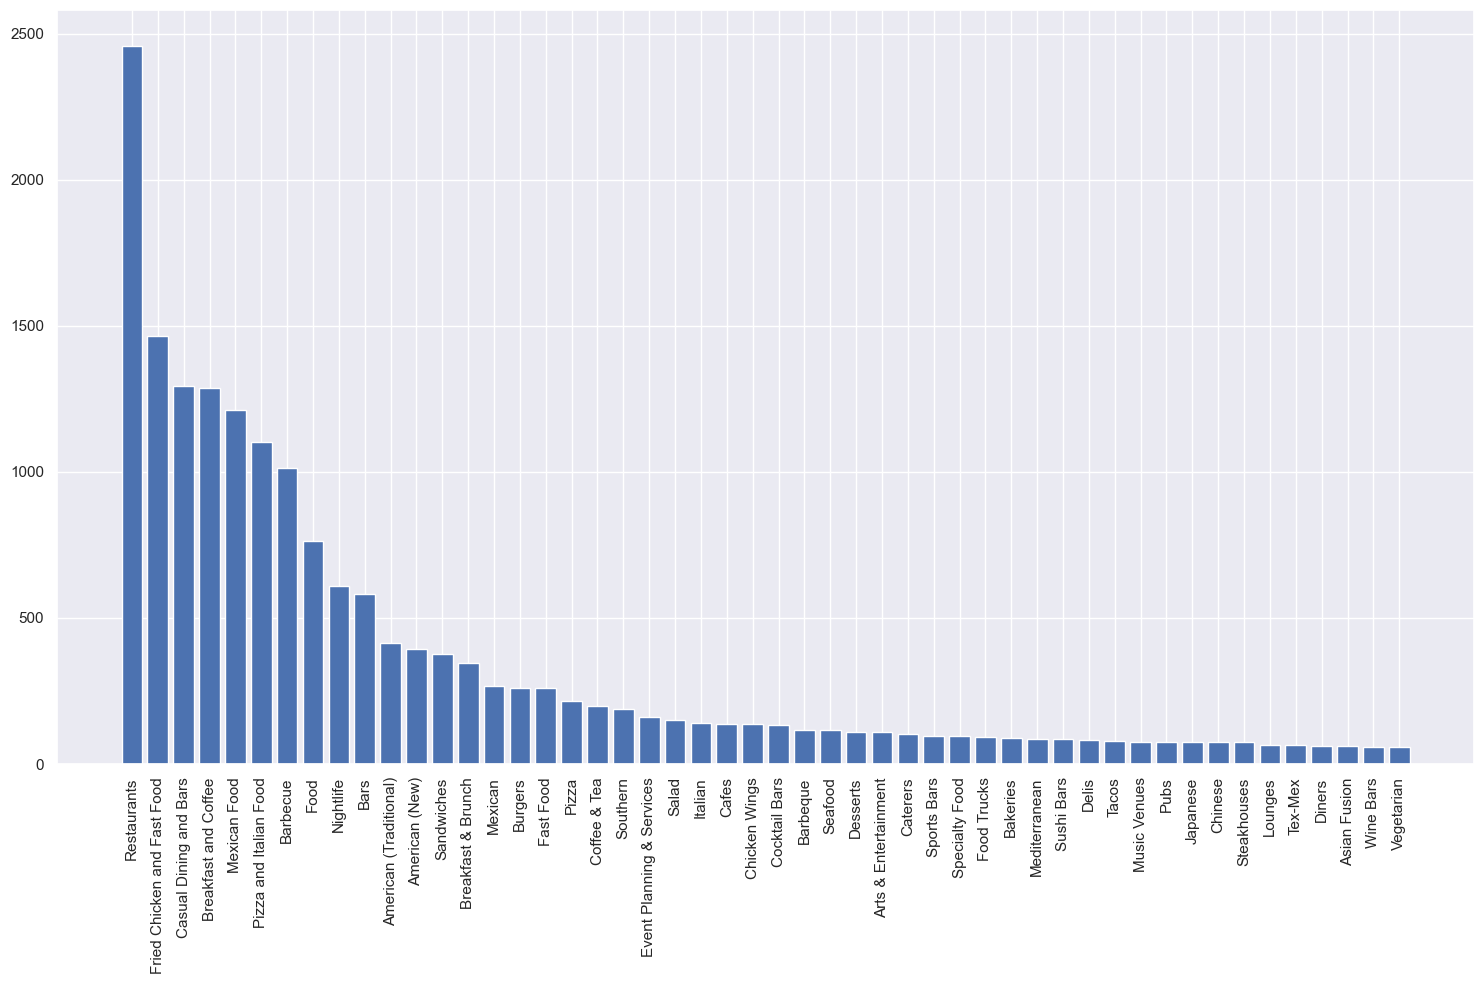

In [77]:
# Let's see the distribution of these categories.
indices = np.arange(len(dict_features_sorted[:50]))
word = []
frequency = []

for i in range(len(dict_features_sorted[:50])):
    word.append(dict_features_sorted[i][0])
    frequency.append(dict_features_sorted[i][1])
plt.figure(figsize=(15,10))
plt.bar(indices, frequency, color='b')
plt.xticks(indices, word, rotation='vertical')
plt.tight_layout()
plt.show()

In [82]:
content_df.head()

,business_id,name,address,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,sep_categories,Dominant Ids,Percent,Topics,Features
0,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,37207,36.208102,-86.768170,1.5,10,1,"{'RestaurantsAttire': ''casual'', 'Restaurants...","Ice Cream & Frozen Yogurt, Fast Food, Burgers,...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '...","[Ice Cream & Frozen Yogurt, Fast Food, Burgers...","[2, 3, 0]","[0.49772567, 0.21415414, 0.08519216]","[Breakfast and Coffee, Fried Chicken and Fast ...","[Ice Cream & Frozen Yogurt, Fast Food, Burgers..."
1,4iRzR7OaS-QaSXuvYxEGKA,Super Dog,1160 Gallatin Pike S,37115,36.248570,-86.719986,4.0,6,0,"{'RestaurantsReservations': 'False', 'Restaura...","Hot Dogs, Restaurants",None,"[Hot Dogs, Restaurants]","[0, 4, 1]","[0.33991277, 0.24837816, 0.18150684]","[Pizza and Italian Food, Casual Dining and Bar...","[Hot Dogs, Restaurants, Pizza and Italian Food..."
2,tMkwHmWFUEXrC9ZduonpTg,The Green Pheasant,215 1st Ave S,37201,36.159886,-86.773197,4.0,161,0,"{'RestaurantsGoodForGroups': 'True', 'HappyHou...","Restaurants, Japanese, Seafood","{'Wednesday': '16:0-22:0', 'Thursday': '16:0-2...","[Restaurants, Japanese, Seafood]","[0, 4, 1]","[0.32599193, 0.31109053, 0.14172961]","[Pizza and Italian Food, Casual Dining and Bar...","[Restaurants, Japanese, Seafood, Pizza and Ita..."
3,lk9IwjZXqUMqqOhM774DtQ,Caviar & Bananas,2031 Broadway,37203,36.148371,-86.798895,3.5,159,0,"{'RestaurantsTakeOut': 'True', 'RestaurantsRes...","Coffee & Tea, Restaurants, Wine Bars, Bars, Ni...","{'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ...","[Coffee & Tea, Restaurants, Wine Bars, Bars, N...","[1, 3, 0]","[0.74089307, 0.083182305, 0.055624004]","[Mexican Food, Fried Chicken and Fast Food, Pi...","[Coffee & Tea, Restaurants, Wine Bars, Bars, N..."
4,oaboaRBUgGjbo2kfUIKDLQ,Mike's Ice Cream,129 2nd Ave N,37201,36.162649,-86.775973,4.5,593,1,"{'RestaurantsGoodForGroups': 'True', 'GoodForK...","Ice Cream & Frozen Yogurt, Coffee & Tea, Resta...","{'Monday': '8:0-23:0', 'Tuesday': '8:0-23:0', ...","[Ice Cream & Frozen Yogurt, Coffee & Tea, Rest...","[4, 3, 2]","[0.77526134, 0.07027646, 0.041649416]","[Casual Dining and Bars, Fried Chicken and Fas...","[Ice Cream & Frozen Yogurt, Coffee & Tea, Rest..."


In [92]:
content_df[content_df['postal_code']=='']

,business_id,name,address,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,sep_categories,Dominant Ids,Percent,Topics,Features
376,jnTnR_eN7hGc7GGzGdUt9Q,The Waffle Boss,,,36.166667,-86.783333,4.0,6,0,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Waffles, Food Trucks, Restaurants, Food",None,"[Waffles, Food Trucks, Restaurants, Food]","[5, 1, 3]","[0.387941, 0.2008235, 0.19935292]","[Barbecue, Mexican Food, Fried Chicken and Fas...","[Waffles, Food Trucks, Restaurants, Food, Barb..."
1060,PFcLisniXcud3ck711Smyw,Jonbalaya,W End Ave,,36.134591,-86.824222,3.0,9,0,"{'Caters': 'True', 'WiFi': 'u'no'', 'Restauran...","Food Trucks, Street Vendors, Food, Food Stands...","{'Tuesday': '7:0-15:0', 'Wednesday': '7:0-15:0...","[Food Trucks, Street Vendors, Food, Food Stand...","[5, 3, 2]","[0.44579464, 0.22531168, 0.1332479]","[Barbecue, Fried Chicken and Fast Food, Breakf...","[Food Trucks, Street Vendors, Food, Food Stand..."


In [83]:
content_df['postal_code'].unique().tolist()

['37207',
 '37115',
 '37201',
 '37203',
 '37214',
 '37209',
 '37219',
 '37212',
 '37211',
 '37204',
 '37215',
 '37205',
 '37243',
 '37221',
 '37206',
 '37228',
 '37217',
 '37013',
 '37208',
 '37216',
 '37067',
 '37220',
 '37210',
 '37076',
 '37026',
 '28801',
 '37218',
 '37011',
 '37027',
 '',
 '37213',
 '37246',
 '37232',
 '37189',
 '37229',
 '37138',
 '32709',
 '37135',
 '37024',
 '37238',
 '37072']

In [84]:
content_df.head()

,business_id,name,address,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,sep_categories,Dominant Ids,Percent,Topics,Features
0,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,37207,36.208102,-86.768170,1.5,10,1,"{'RestaurantsAttire': ''casual'', 'Restaurants...","Ice Cream & Frozen Yogurt, Fast Food, Burgers,...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '...","[Ice Cream & Frozen Yogurt, Fast Food, Burgers...","[2, 3, 0]","[0.49772567, 0.21415414, 0.08519216]","[Breakfast and Coffee, Fried Chicken and Fast ...","[Ice Cream & Frozen Yogurt, Fast Food, Burgers..."
1,4iRzR7OaS-QaSXuvYxEGKA,Super Dog,1160 Gallatin Pike S,37115,36.248570,-86.719986,4.0,6,0,"{'RestaurantsReservations': 'False', 'Restaura...","Hot Dogs, Restaurants",None,"[Hot Dogs, Restaurants]","[0, 4, 1]","[0.33991277, 0.24837816, 0.18150684]","[Pizza and Italian Food, Casual Dining and Bar...","[Hot Dogs, Restaurants, Pizza and Italian Food..."
2,tMkwHmWFUEXrC9ZduonpTg,The Green Pheasant,215 1st Ave S,37201,36.159886,-86.773197,4.0,161,0,"{'RestaurantsGoodForGroups': 'True', 'HappyHou...","Restaurants, Japanese, Seafood","{'Wednesday': '16:0-22:0', 'Thursday': '16:0-2...","[Restaurants, Japanese, Seafood]","[0, 4, 1]","[0.32599193, 0.31109053, 0.14172961]","[Pizza and Italian Food, Casual Dining and Bar...","[Restaurants, Japanese, Seafood, Pizza and Ita..."
3,lk9IwjZXqUMqqOhM774DtQ,Caviar & Bananas,2031 Broadway,37203,36.148371,-86.798895,3.5,159,0,"{'RestaurantsTakeOut': 'True', 'RestaurantsRes...","Coffee & Tea, Restaurants, Wine Bars, Bars, Ni...","{'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ...","[Coffee & Tea, Restaurants, Wine Bars, Bars, N...","[1, 3, 0]","[0.74089307, 0.083182305, 0.055624004]","[Mexican Food, Fried Chicken and Fast Food, Pi...","[Coffee & Tea, Restaurants, Wine Bars, Bars, N..."
4,oaboaRBUgGjbo2kfUIKDLQ,Mike's Ice Cream,129 2nd Ave N,37201,36.162649,-86.775973,4.5,593,1,"{'RestaurantsGoodForGroups': 'True', 'GoodForK...","Ice Cream & Frozen Yogurt, Coffee & Tea, Resta...","{'Monday': '8:0-23:0', 'Tuesday': '8:0-23:0', ...","[Ice Cream & Frozen Yogurt, Coffee & Tea, Rest...","[4, 3, 2]","[0.77526134, 0.07027646, 0.041649416]","[Casual Dining and Bars, Fried Chicken and Fas...","[Ice Cream & Frozen Yogurt, Coffee & Tea, Rest..."


In [87]:
len(set(content_df['business_id']))

2458

In [89]:
len(set(nash_stars['business_id']))

2501

In [85]:
set(content_df['business_id']) == set(nash_stars['business_id'])

False

In [93]:
content_df = content_df.merge(nash_stars,on='business_id')

In [94]:
with open('nash_contents.pkl', 'wb') as fp:
    pickle.dump(content_df, fp)